# Duolingo Churn Project

# Introduction

This project explores key factors contributing to user churn on Duolingo, aiming to provide actionable recommendations for the team to improve retention. The analysis was guided by two high-level questions:

1. **What causes users to churn?**  
2. **What actionable strategies can reduce churn?**

To address these questions, the project followed a structured approach:

### 1. Exploratory Analysis
I began by analyzing demographic and behavioral data, including user age, gender, number of friends, and most active times. This provides insights into general trends and patterns among users.

### 2. Correlation with Churn
Next, I identified variables with the strongest correlations to churn, which show the characteristics and behaviors most associated with users leaving the platform.

### 3. Predictive Modeling
I developed a logistic regression model to understand which factors predict churn. This helps quantify the influence of various user attributes and behaviors on retention.

### 4. Advanced Modeling with XGBoost
I implemented grid search and XGBoost to identify the strongest predictors of reduced churn. This investigates factors the product team should prioritize in retention strategies.

Through these steps, I uncovered actionable insights and recommendations for enhancing user retention and reducing churn on Duolingo.


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate


df_duolingo_expanded = pd.read_csv("/Users/andreaseet/Downloads/Data Science/Duolingo Project/df_duolingo_expanded.csv")

# About the Data

### Dataset Explanation for Duolingo:

- **UserID**: Unique identifier for each user.
- **Age**: Age of the user.
- **Gender**: Gender of the user (Male/Female/Non-binary).
- **SubscriptionType**: Whether the user is on a Free or Plus (premium) subscription.
- **LearningStreakDays**: Number of consecutive days the user has been active on Duolingo.
- **TotalLessonsCompleted**: Total number of lessons the user has completed.
- **AvgSessionsPerWeek**: Average number of sessions per week the user engages in.
- **TotalLanguagesLearning**: Total number of languages the user is learning.
- **FavoriteLanguage**: The language that the user spends the most time learning.
- **IsPartOfClub**: Whether the user is part of a Duolingo club (0 for No, 1 for Yes).
- **NumFriends**: Number of friends the user has on Duolingo.
- **NumBadgesEarned**: Number of badges the user has earned.
- **IsPremiumUser**: Whether the user is a premium user (1 for Yes, 0 for No).
- **HasNotificationsOn**: Whether the user has notifications turned on (0 for No, 1 for Yes).
- **LastActiveDaysAgo**: Number of days since the user was last active on the platform.
- **Churn**: The target variable indicating whether the user churned (1 for churned, 0 for not churned).
- **AccountAgeDays**: Number of days since the user created their account.
- **AvgTimeSpentPerSession**: Average time spent per session (in minutes).
- **HasProfilePicture**: Whether the user has uploaded a profile picture (0 for No, 1 for Yes).
- **CompletedLevels**: Total number of levels the user has completed across all languages.
- **NumLanguagesMastered**: Number of languages the user has mastered (fully completed all levels).
- **MostRecentActivity**: Type of activity the user engaged in most recently (e.g., Lesson, Practice, Test, Discussion).
- **IsMobileUser**: Whether the user primarily uses a mobile device for learning (0 for No, 1 for Yes).
- **NumDaysSinceLastPayment**: For premium users, the number of days since the last payment.
- **NumCoursesStarted**: Number of courses (languages) the user has started.
- **TimeOfDayMostActive**: The time of day when the user is most active (Morning, Afternoon, Evening, Night).
- **EducationLevel**: The user's highest level of education (e.g., High School, Bachelor, Master, Doctorate).
- **StreakFreezeUsed**: Whether the user used a streak freeze to maintain their learning streak (0 for No, 1 for Yes).
- **FrequencyOfAppUsage**: How often the user uses the app (e.g., Daily, Weekly, Monthly).
- **XPPointsEarned**: The number of XP (experience points) the user has earned, reflecting their interaction with the app's gamified elements.
- **LeaderboardPosition**: The user's position on the leaderboard, indicating their competitive standing.
- **TimeOfDayMostActive**: The time of day when the user is most active on the app (Morning, Afternoon, Evening, Night).

In [30]:
df_duolingo_expanded

,UserID,Age,Gender,EducationLevel,SubscriptionType,LearningStreakDays,StreakFreezeUsed,TotalLessonsCompleted,NumLanguagesMastered,AvgSessionsPerWeek,...,LastActiveDaysAgo,AccountAgeDays,AvgTimeSpentPerSession,HasProfilePicture,CompletedLevels,MostRecentActivity,IsMobileUser,NumDaysSinceLastPayment,NumCoursesStarted,Churn
0,1,36,Female,Master,Plus,33,0,84,2,2.881971,...,72,64,8.717173,1,40,Lesson,1,155,0,0
1,2,41,Male,Bachelor,Free,38,0,252,0,5.472369,...,2,142,9.272420,1,1,Lesson,1,12,6,1
2,3,33,Female,High School,Free,40,1,87,2,2.719976,...,0,564,14.608819,1,6,Lesson,1,121,1,0
3,4,24,Male,Bachelor,Free,8,0,24,0,2.039025,...,34,827,12.453016,1,9,Lesson,0,222,4,0
4,5,32,Female,Doctorate,Plus,9,0,15,0,1.591298,...,84,337,16.836295,1,10,Lesson,0,48,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,37,Male,Bachelor,Plus,12,0,226,2,3.699189,...,41,177,6.570230,0,20,Lesson,0,141,6,0
49996,49997,35,Female,High School,Free,5,0,79,4,3.715616,...,40,416,11.131812,0,20,Lesson,0,167,2,0
49997,49998,21,Female,Bachelor,Plus,30,0,15,0,2.026215,...,60,537,7.687760,0,5,Practice,1,68,1,0
49998,49999,32,Male,High School,Free,24,0,162,2,2.423220,...,26,54,12.762852,0,18,Discussion,1,13,2,0


# Exploratory Analyses

I first created visualizations of demographic and app usage data to uncover potential patterns and trends, providing a foundational understanding of user behavior.

In [31]:
# Define the age bins and labels
bins = [0, 18, 25, 35, 45, 60, 100] 
labels = ['0-18', '19-25', '26-35', '36-45', '46-60', '60+'] 

# Create a new column 'Age_Bucket' in the DataFrame
df_duolingo_expanded['Age_Bucket'] = pd.cut(df_duolingo_expanded['Age'], bins=bins, labels=labels, right=False)


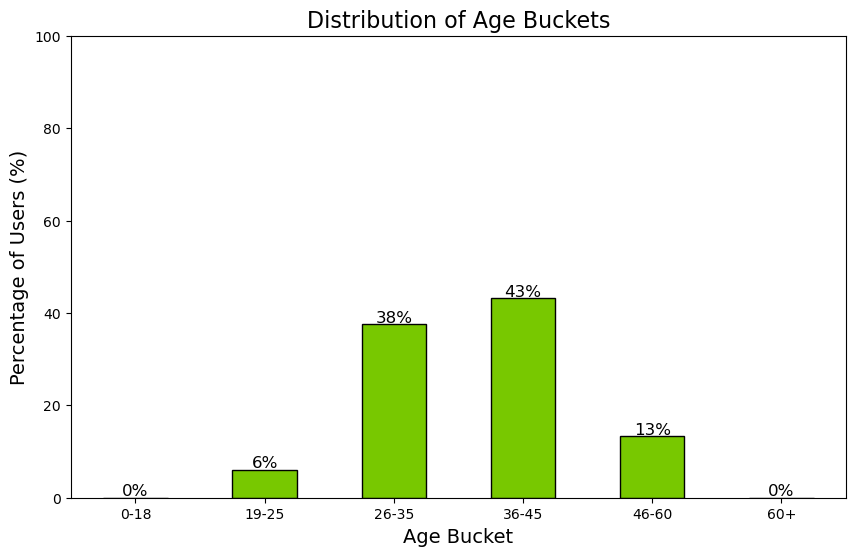

In [32]:

# Calculate the percentage of users in each age bucket
age_bucket_percentages = (
    df_duolingo_expanded['Age_Bucket']
    .value_counts(normalize=True)  # Get normalized counts (proportions)
    .sort_index() * 100  # Sort by index and convert to percentage
)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = age_bucket_percentages.plot(kind='bar', color='#78C800', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Age Buckets', fontsize=16)
plt.xlabel('Age Bucket', fontsize=14)
plt.ylabel('Percentage of Users (%)', fontsize=14)
plt.xticks(rotation=0)
plt.ylim(0, 100)

# Annotate percentages on each bar (rounded to the nearest whole number)
for i, percentage in enumerate(age_bucket_percentages):
    plt.text(i, percentage + 0.5, f'{round(percentage)}%', ha='center', fontsize=12, color='black')

# Display the plot
plt.show()



We see that 81% of Duolingo users are ages 26-45. The Duolingo user base is primarily of younger and middle aged people.

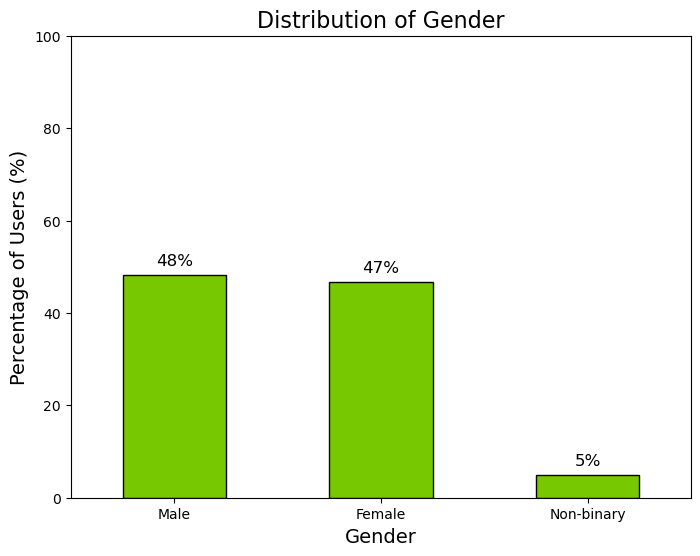

In [33]:

# Calculate the percentage of users for each gender
gender_percentages = (
    df_duolingo_expanded['Gender']
    .value_counts(normalize=True)  # Get normalized counts (proportions)
    * 100  # Convert to percentages
)

# Create a bar plot with Duolingo green color
plt.figure(figsize=(8, 6))
bars = gender_percentages.plot(kind='bar', color='#78C800', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Percentage of Users (%)', fontsize=14)
plt.xticks(rotation=0)

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Annotate percentages on each bar (rounded to the nearest whole number)
for i, percentage in enumerate(gender_percentages):
    plt.text(i, percentage + 2, f'{round(percentage)}%', ha='center', fontsize=12, color='black')

# Display the plot
plt.show()


The distribution of males and females on Duolingo is fairly balanced.

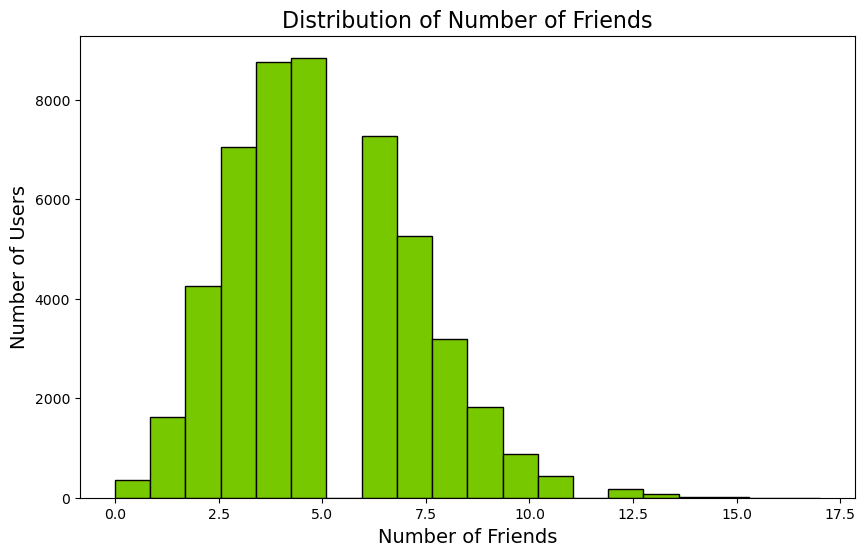

In [34]:
# Create a histogram for the NumFriends column
plt.figure(figsize=(10, 6))
plt.hist(df_duolingo_expanded['NumFriends'], bins=20, color='#78C800', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Number of Friends', fontsize=16)
plt.xlabel('Number of Friends', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)

# Display the plot
plt.show()

The distribution of the number of friends that users have is right tailed with most users having at least 2 but not more than 10 friends.

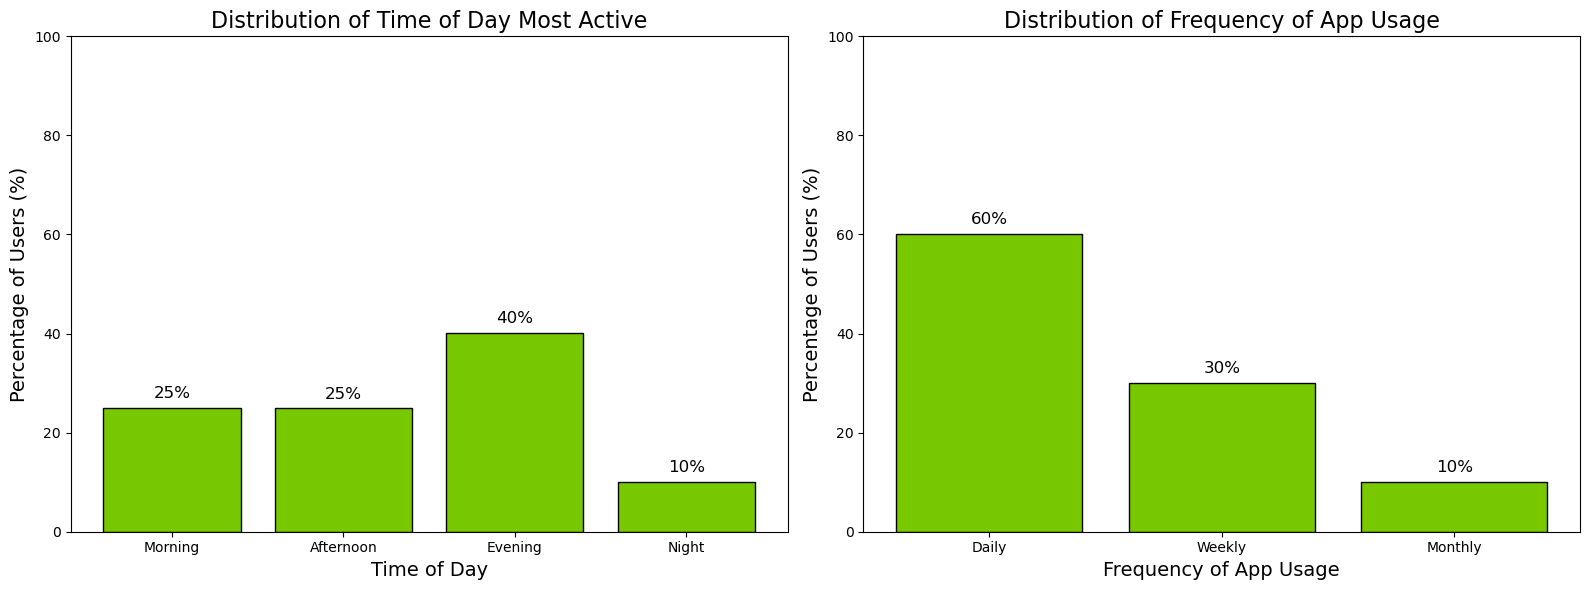

In [35]:

# Define custom order for TimeOfDayMostActive and FrequencyOfAppUsage
time_of_day_order = ['Morning', 'Afternoon', 'Evening', 'Night']
frequency_order = ['Daily', 'Weekly', 'Monthly']

# Reorder the TimeOfDayMostActive percentages
time_of_day_percentages = (
    df_duolingo_expanded['TimeOfDayMostActive']
    .value_counts(normalize=True)
    .reindex(time_of_day_order)  # Apply the custom order
    * 100
)

# Reorder the FrequencyOfAppUsage percentages
frequency_of_app_usage_percentages = (
    df_duolingo_expanded['FrequencyOfAppUsage']
    .value_counts(normalize=True)
    .reindex(frequency_order)  # Apply the custom order
    * 100
)

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for TimeOfDayMostActive
axes[0].bar(time_of_day_percentages.index, time_of_day_percentages.values, color='#78C800', edgecolor='black')
axes[0].set_title('Distribution of Time of Day Most Active', fontsize=16)
axes[0].set_xlabel('Time of Day', fontsize=14)
axes[0].set_ylabel('Percentage of Users (%)', fontsize=14)
axes[0].set_ylim(0, 100)  # Set y-axis limit to 100%
axes[0].tick_params(axis='x', rotation=0)

# Annotate percentages on each bar
for i, percentage in enumerate(time_of_day_percentages):
    if not pd.isna(percentage):  # Avoid errors with NaN values
        axes[0].text(i, percentage + 2, f'{round(percentage)}%', ha='center', fontsize=12, color='black')

# Plot for FrequencyOfAppUsage
axes[1].bar(frequency_of_app_usage_percentages.index, frequency_of_app_usage_percentages.values, color='#78C800', edgecolor='black')
axes[1].set_title('Distribution of Frequency of App Usage', fontsize=16)
axes[1].set_xlabel('Frequency of App Usage', fontsize=14)
axes[1].set_ylabel('Percentage of Users (%)', fontsize=14)
axes[1].set_ylim(0, 100)  # Set y-axis limit to 100%
axes[1].tick_params(axis='x', rotation=0)

# Annotate percentages on each bar
for i, percentage in enumerate(frequency_of_app_usage_percentages):
    if not pd.isna(percentage):  # Avoid errors with NaN values
        axes[1].text(i, percentage + 2, f'{round(percentage)}%', ha='center', fontsize=12, color='black')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


Most people are active on Duolingo in the evening, which could potentially be due to users having the most free time in the evening. We also observe that 60% of Duolingo users are on the app daily with 30% of users on the app weekly.

# Correlations with Churn

In [36]:
# Calculate churn rate by EducationLevel
churn_by_education = df_duolingo_expanded.groupby('EducationLevel')['Churn'].mean().reset_index()

# Rename the column for clarity
churn_by_education.columns = ['EducationLevel', 'ChurnRate']

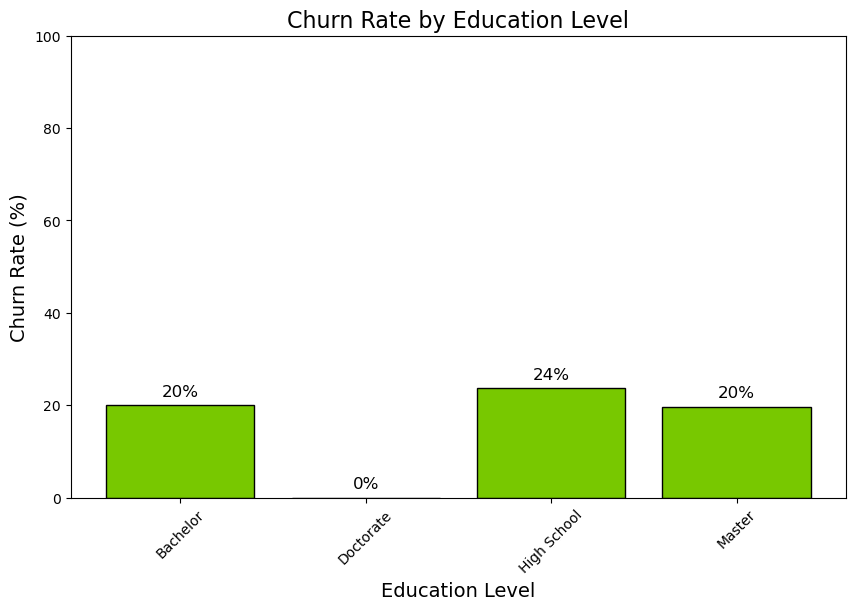

In [37]:
# Convert churn rate to percentages
churn_by_education['ChurnRate'] = churn_by_education['ChurnRate'] * 100

# Create a bar plot to visualize churn rate by education level
plt.figure(figsize=(10, 6))
plt.bar(churn_by_education['EducationLevel'], churn_by_education['ChurnRate'], color='#78C800', edgecolor='black')

# Add titles and labels
plt.title('Churn Rate by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(rotation=45)

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Annotate percentages on each bar
for i, churn_rate in enumerate(churn_by_education['ChurnRate']):
    plt.text(i, churn_rate + 2, f'{round(churn_rate)}%', ha='center', fontsize=12, color='black')

# Display the plot
plt.show()


In [38]:
# Calculate the percentage of users with doctorates
total_users = len(df_duolingo_expanded)
doctorate_users = df_duolingo_expanded[df_duolingo_expanded['EducationLevel'] == 'Doctorate'].shape[0]
percentage_doctorate_users = (doctorate_users / total_users) * 100

# Print the result
print(f"Percentage of users with doctorates: {percentage_doctorate_users:.2f}%")


Percentage of users with doctorates: 7.91%


No users with doctorates churned, despite representing 8% of the total user base. This suggests a strong retention rate among users with doctoral degrees.

In [39]:
# Create buckets for NumFriends
bins = [0, 5, 10, 20]  # Define the bin edges for 0-4, 5-9, 10-19
labels = ['0-4', '5-9', '10-19']  # Define the bucket labels

# Create a new column for NumFriendsBucket
df_duolingo_expanded['NumFriendsBucket'] = pd.cut(
    df_duolingo_expanded['NumFriends'], bins=bins, labels=labels, right=False
)

# Calculate churn rate by NumFriendsBucket
churn_by_num_friends = df_duolingo_expanded.groupby('NumFriendsBucket')['Churn'].mean().reset_index()

# Rename the column for clarity
churn_by_num_friends.columns = ['NumFriendsBucket', 'ChurnRate']


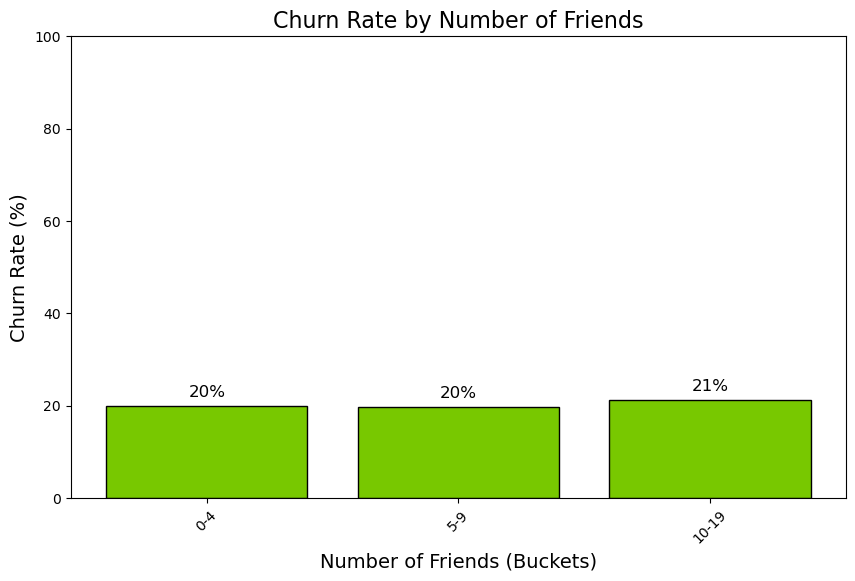

In [40]:
# Convert churn rate to percentages
churn_by_num_friends['ChurnRate'] = churn_by_num_friends['ChurnRate'] * 100

# Create a bar plot to visualize churn rate by number of friends
plt.figure(figsize=(10, 6))
plt.bar(churn_by_num_friends['NumFriendsBucket'], churn_by_num_friends['ChurnRate'], color='#78C800', edgecolor='black')

# Add titles and labels
plt.title('Churn Rate by Number of Friends', fontsize=16)
plt.xlabel('Number of Friends (Buckets)', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.xticks(rotation=45)

# Set y-axis limit to 100%
plt.ylim(0, 100)

# Annotate percentages on each bar
for i, churn_rate in enumerate(churn_by_num_friends['ChurnRate']):
    plt.text(i, churn_rate + 2, f'{round(churn_rate)}%', ha='center', fontsize=12, color='black')

# Display the plot
plt.show()


The analysis reveals no significant variation in churn rates across different friend count buckets. This indicates that the number of friends a user has is not a strong predictor of churn, suggesting that other factors may be more influential in determining user retention.

In [41]:
# Encode categorical variables (if needed)
df_encoded = df_duolingo_expanded.copy()

# Convert categorical columns to numerical using one-hot encoding or label encoding
# For simplicity, let's do label encoding on binary categorical columns
from sklearn.preprocessing import LabelEncoder

# Columns that can be label encoded directly
binary_cols = ['Gender', 'SubscriptionType', 'EducationLevel', 'FavoriteLanguage', 
               'MostRecentActivity', 'TimeOfDayMostActive']

# Label encoding
le = LabelEncoder()
for col in binary_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Now calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Extract correlations with the Churn variable
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)

# Display the correlation values with Churn
print(churn_correlation)


Churn                      1.000000
Age                        0.524457
LastActiveDaysAgo          0.176110
AccountAgeDays             0.067894
EducationLevel             0.032747
NumDaysSinceLastPayment    0.007669
NumCoursesStarted          0.005444
FavoriteLanguage           0.004097
LeaderboardPosition        0.003092
MostRecentActivity         0.002588
IsMobileUser               0.001167
NumFriends                 0.000813
AvgTimeSpentPerSession     0.000701
XPPointsEarned             0.000695
HasProfilePicture         -0.000454
NumBadgesEarned           -0.000700
Gender                    -0.001923
UserID                    -0.003228
HasNotificationsOn        -0.003328
CompletedLevels           -0.004857
IsPartOfClub              -0.006290
TimeOfDayMostActive       -0.007389
StreakFreezeUsed          -0.009627
IsPremiumUser             -0.089000
SubscriptionType          -0.089000
TotalLessonsCompleted     -0.168503
LearningStreakDays        -0.171244
NumLanguagesMastered      -0

Top 5 correlations with Churn:
Age                     0.524457
AvgSessionsPerWeek     -0.263212
NumLanguagesMastered   -0.225635
LastActiveDaysAgo       0.176110
LearningStreakDays     -0.171244
Name: Churn, dtype: float64


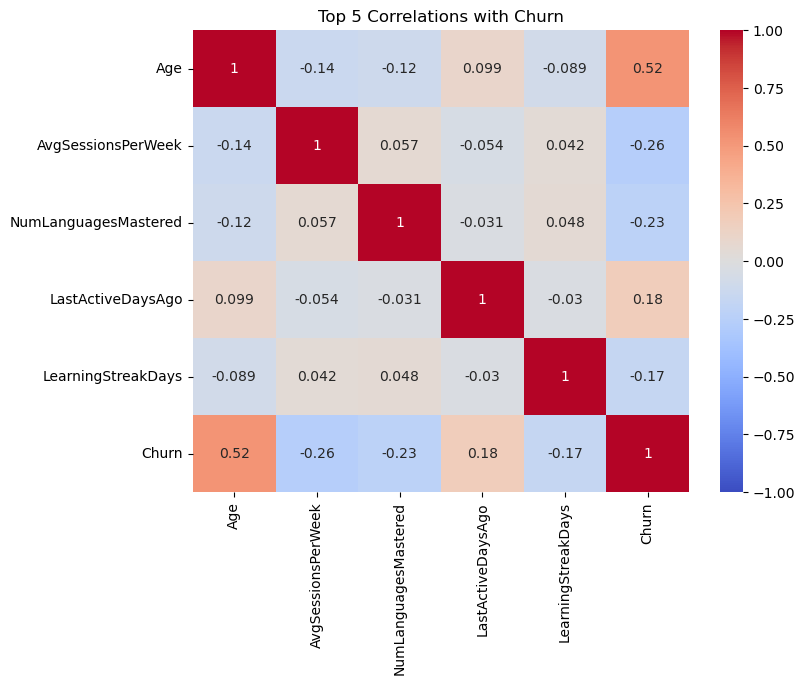

In [42]:

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Extract correlations with the Churn variable, keeping the signs, and sort by absolute value
churn_correlation = correlation_matrix['Churn'].iloc[:-1]  # Exclude self-correlation
sorted_correlation = churn_correlation.reindex(churn_correlation.abs().sort_values(ascending=False).index)

# Get the top 5 correlations (by absolute value)
top_5_correlation = sorted_correlation.head(5)
print("Top 5 correlations with Churn:")
print(top_5_correlation)

# Create a heatmap for the top 5 correlations
selected_columns = top_5_correlation.index.to_list() + ['Churn']
plt.figure(figsize=(8, 6))
sns.heatmap(df_encoded[selected_columns].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 5 Correlations with Churn')
plt.show()

## Correlation Interpretation

As age increases, the likelihood of churn (or the value of Churn) tends to increase. This suggests that older users are more likely to churn. Older users may have different priorities or less time to engage with the platform compared to younger users. 

As the average number of sessions per week increases, the likelihood of churn decreases. This suggests that users who engage more frequently with the platform are less likely to churn.

# Logistic Regression 

To predict which variables influence churn, I built a logistic regression model. This approach allows me to identify significant predictors of churn and quantify their impact. 

In [43]:
# Define the predictors including an extensive set of important variables
X = df_encoded[['Age', 'AvgSessionsPerWeek', 'EducationLevel', 'SubscriptionType',
                          'LearningStreakDays', 'TotalLessonsCompleted', 'NumLanguagesMastered',
                          'LastActiveDaysAgo', 'AccountAgeDays', 'StreakFreezeUsed',
                          'NumFriends', 'NumBadgesEarned', 'XPPointsEarned', 'LeaderboardPosition',
                          'HasNotificationsOn', 'IsPartOfClub', 'AvgTimeSpentPerSession',
                          'HasProfilePicture', 'CompletedLevels', 'IsMobileUser', 'NumCoursesStarted']]

# Convert categorical variables to dummy/indicator variables (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Define the target variable
y = df_encoded['Churn']

# Add a constant to the predictors (required for statsmodels)
X = sm.add_constant(X)

In [44]:
X

,const,Age,AvgSessionsPerWeek,EducationLevel,SubscriptionType,LearningStreakDays,TotalLessonsCompleted,NumLanguagesMastered,LastActiveDaysAgo,AccountAgeDays,...,NumBadgesEarned,XPPointsEarned,LeaderboardPosition,HasNotificationsOn,IsPartOfClub,AvgTimeSpentPerSession,HasProfilePicture,CompletedLevels,IsMobileUser,NumCoursesStarted
0,1.0,36,2.881971,3,1,33,84,2,72,64,...,5,9549,502,1,0,8.717173,1,40,1,0
1,1.0,41,5.472369,0,0,38,252,0,2,142,...,3,9131,793,1,0,9.272420,1,1,1,6
2,1.0,33,2.719976,2,0,40,87,2,0,564,...,3,9532,250,1,0,14.608819,1,6,1,1
3,1.0,24,2.039025,0,0,8,24,0,34,827,...,6,4240,348,1,1,12.453016,1,9,0,4
4,1.0,32,1.591298,1,1,9,15,0,84,337,...,10,2998,620,1,1,16.836295,1,10,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.0,37,3.699189,0,1,12,226,2,41,177,...,4,4417,706,1,0,6.570230,0,20,0,6
49996,1.0,35,3.715616,2,0,5,79,4,40,416,...,4,5404,44,1,0,11.131812,0,20,0,2
49997,1.0,21,2.026215,0,1,30,15,0,60,537,...,8,4659,483,0,0,7.687760,0,5,1,1
49998,1.0,32,2.423220,2,0,24,162,2,26,54,...,5,3599,755,1,0,12.762852,0,18,1,2


In [45]:

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                   feature        VIF
0                    const  77.801068
1                      Age   1.055168
2       AvgSessionsPerWeek   1.025317
3           EducationLevel   1.000812
4         SubscriptionType   1.003122
5       LearningStreakDays   1.011021
6    TotalLessonsCompleted   1.010002
7     NumLanguagesMastered   1.018144
8        LastActiveDaysAgo   1.013243
9           AccountAgeDays   1.002208
10        StreakFreezeUsed   1.000508
11              NumFriends   1.000339
12         NumBadgesEarned   1.000398
13          XPPointsEarned   1.000232
14     LeaderboardPosition   1.000331
15      HasNotificationsOn   1.000332
16            IsPartOfClub   1.000709
17  AvgTimeSpentPerSession   1.000367
18       HasProfilePicture   1.000437
19         CompletedLevels   1.000296
20            IsMobileUser   1.000228
21       NumCoursesStarted   1.000424


I checked the Variance Inflation Factor (VIF) to assess multicollinearity among the predictor variables in the logistic regression model. I did not see any variables that had high VIFs.

In [46]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the logistic regression model
logit_model = sm.Logit(y_train, X_train)

# Fit the model
result = logit_model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.265951
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                35000
Model:                          Logit   Df Residuals:                    34978
Method:                           MLE   Df Model:                           21
Date:                Mon, 09 Dec 2024   Pseudo R-squ.:                  0.4672
Time:                        20:09:14   Log-Likelihood:                -9308.3
converged:                       True   LL-Null:                       -17470.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.9294      0.185    -42.844      0.000      -8.292      

The logistic regression model identifies key predictors of churn, such as Age, AvgSessionsPerWeek, NumLanguagesMastered.

For every one-year increase in age, the odds of churn increase by approximately 27.3%, holding all other variables constant. Older age increase churn likelihood while higher engagement through more sessions reduces churn likelihood significantly, highlighting the importance of fostering consistent user activity.

For every additional session per week, the odds of churn decrease by approximately 40.2%, holding all other variables constant.

Next, I used lasso regularization to drive some coefficients to exactly zero, for feature selection. I also used cross-validation to find the best hyperparameters for logistic regression by testing multiple options. It ensures the model performs well on unseen data.

In [47]:

# Step 1: Hyperparameter Optimization with Grid Search
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

# Use the best parameters for the final model
best_C = grid_search.best_params_['C']
logit_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C, max_iter=100)
logit_model.fit(X_train, y_train)


Best parameters: {'C': 100}
Best cross-validation score: 0.8872


LogisticRegression(C=100, penalty='l1', solver='liblinear')

Accuracy: 0.8853
Confusion Matrix:
[[11503   539]
 [ 1181  1777]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     12042
           1       0.77      0.60      0.67      2958

    accuracy                           0.89     15000
   macro avg       0.84      0.78      0.80     15000
weighted avg       0.88      0.89      0.88     15000

AUC-ROC: 0.9196


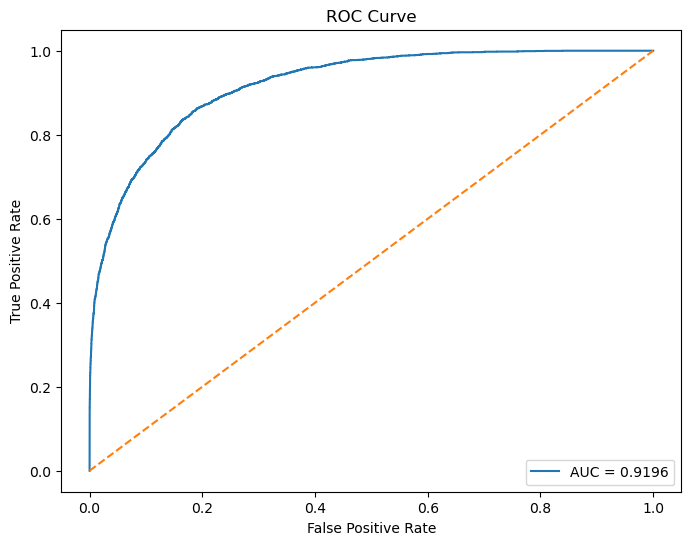

In [48]:
# Predict probabilities of the positive class (Churn = 1)
y_pred_prob = logit_model.predict_proba(X_test)[:, 1]

# Predict binary outcomes (0 or 1)
y_pred = logit_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC-ROC: {auc_roc:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

 The 92% AUC-ROC indicates that the model explains a significant proportion of the variability in churn.

In [49]:
# Add a constant for the intercept
X_train_with_const = sm.add_constant(X_train)

# Fit the model using statsmodels
logit_model_sm = sm.Logit(y_train, X_train_with_const)
result = logit_model_sm.fit()

# Extract coefficients, p-values, and calculate odds ratios
coef = result.params
p_values = result.pvalues
odds_ratios = np.exp(coef)

# Calculate 95% Confidence Intervals
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']
conf['OR 2.5%'] = np.exp(conf['2.5%'])
conf['OR 97.5%'] = np.exp(conf['97.5%'])

# Print feature statistics with 95% CI
print(f"{'Feature':<25} {'Coefficient':<15} {'Odds Ratio':<15} {'OR 2.5%':<15} {'OR 97.5%':<15} {'p-value':<15}")
print("="*90)
for feature, coef_value, odds_ratio, or_2_5, or_97_5, p_value in zip(coef.index, coef, odds_ratios, conf['OR 2.5%'], conf['OR 97.5%'], p_values):
    print(f"{feature:<25} {coef_value:<15.6f} {odds_ratio:<15.4f} {or_2_5:<15.4f} {or_97_5:<15.4f} {p_value:<15.6f}")


Optimization terminated successfully.
         Current function value: 0.265951
         Iterations 8
Feature                   Coefficient     Odds Ratio      OR 2.5%         OR 97.5%        p-value        
const                     -7.929400       0.0004          0.0003          0.0005          0.000000       
Age                       0.241935        1.2737          1.2650          1.2825          0.000000       
AvgSessionsPerWeek        -0.513719       0.5983          0.5817          0.6153          0.000000       
EducationLevel            0.106803        1.1127          1.0767          1.1499          0.000000       
SubscriptionType          -0.443215       0.6420          0.5952          0.6924          0.000000       
LearningStreakDays        -0.028463       0.9719          0.9698          0.9741          0.000000       
TotalLessonsCompleted     -0.005530       0.9945          0.9940          0.9949          0.000000       
NumLanguagesMastered      -0.714491       0.4894  

Statistical Significance: The features with p-values less than 0.05 are statistically significant, meaning there is strong evidence that these features are associated with the likelihood of churn.

Predictors That Increase Churn

- **Age**: Each additional year of age increases churn odds by **27.4%**, with an odds ratio of **1.27** (95% CI: 1.27–1.28, \(p<0.001\)). 

Predictors That Reduce Churn

- **AvgSessionsPerWeek**: More frequent weekly sessions reduce churn odds by **40.2%**, with an odds ratio of **0.6** (95% CI: 0.58–0.62, \(p<0.001\)).  
- **NumLanguagesMastered**: Each additional language mastered reduces churn odds by **51.1%**, with an odds ratio of **0.49** (95% CI: 0.47–0.51, \(p<0.001\)).  

- **SubscriptionType**: Premium plans reduce churn odds by **35.8%**, supporting retention.


Takeaways

Older age users are more likely to churn, while frequent sessions, mastering more languages, and engaging with premium subscription plans significantly reduce churn odds.

## XG Boost

To achieve greater predictive accuracy and effectively capture complex patterns and feature interactions in the data, I implemented an XGBoost model.

Model 1 XGBoost

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees to build
    max_depth=6,       # Maximum depth of a tree
    learning_rate=0.1, # Step size shrinkage
    subsample=0.8,     # Subsample ratio of the training instance
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42    # Random seed for reproducibility
)

# Train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Validation set for early stopping
    early_stopping_rounds=10,  # Stop if no improvement in 10 rounds
    verbose=False  # Suppress verbose output
)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [63]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8953


In [64]:
# Print classification report
print(classification_report(y_test, y_pred))

# AUC-ROC score
y_pred_proba = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      8036
           1       0.82      0.60      0.69      1964

    accuracy                           0.90     10000
   macro avg       0.86      0.78      0.81     10000
weighted avg       0.89      0.90      0.89     10000

AUC-ROC: 0.9310


Model 2 (Model 1 with cross validation)

In [62]:
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,       # Number of trees to build
    max_depth=6,            # Maximum depth of a tree
    learning_rate=0.1,      # Step size shrinkage
    subsample=0.8,          # Subsample ratio of the training instance
    colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
    random_state=42         # Random seed for reproducibility
)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',  # Accuracy metric
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)  # AUC-ROC metric
}

# Perform 5-fold cross-validation
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Print results
print("Cross-Validation Accuracy (mean):", cv_results['test_accuracy'].mean())
print("Cross-Validation AUC-ROC (mean):", cv_results['test_roc_auc'].mean())

Cross-Validation Accuracy (mean): 0.891525
Cross-Validation AUC-ROC (mean): 0.9294149306777235


The accuracy and AUC-ROC are lower using cross-validation. Cross-validation often yields slightly lower metrics because the model trains on smaller subsets of data and is evaluated on multiple unseen folds, providing a more realistic measure of generalization.

Model 3: Grid search to determine the best parameters

In [65]:
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, scoring='roc_auc', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy: {accuracy:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best Model Accuracy: 0.8944


In [66]:
from sklearn.metrics import roc_auc_score

# Get probability predictions for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9315


We will use model 3 with grid search as it produces a model that ensures that hyperparameters are optimized for performance to generalize well on unseen data with slightly higher ROC-AUC and accuracy.

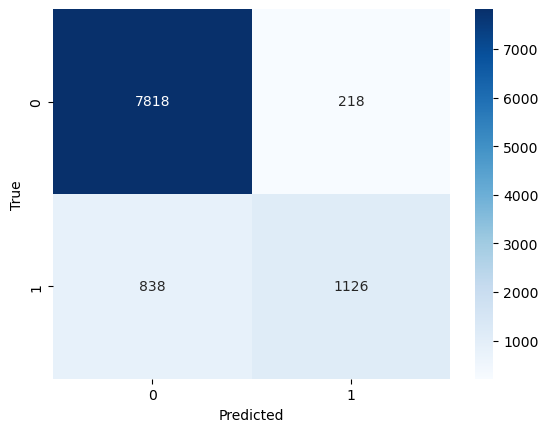

In [67]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
# Print classification report
print(classification_report(y_test, y_pred))

# AUC-ROC score
y_pred_proba = best_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      8036
           1       0.84      0.57      0.68      1964

    accuracy                           0.89     10000
   macro avg       0.87      0.77      0.81     10000
weighted avg       0.89      0.89      0.89     10000

AUC-ROC: 0.9315


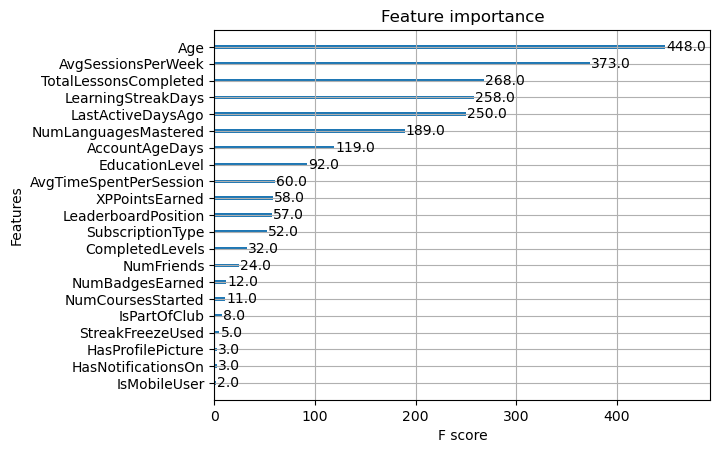

In [69]:
xgb.plot_importance(best_model)
plt.show()

### Most Influential Features in the Model

1. **Age**  
   Reflects significant demographic differences in user behavior, with younger users often exhibiting higher engagement levels and lower churn likelihood, while older users may face barriers like time constraints or lower tech familiarity, making age a critical determinant of platform retention.

2. **Average Sessions Per Week**  
   Indicates the consistency of user engagement, with higher values typically associated with lower churn likelihood.

3. **Total Lessons Completed**  
   Reflects overall user activity and progress, where more completed lessons suggest greater investment in the platform.

4. **Last Active Days Ago**  
   Measures the recency of activity, with a higher number of inactive days potentially signaling disengagement and increased churn risk.


In [41]:
# Save the model
joblib.dump(model, 'xgboost_churn_model.pkl')

# Later, you can load the model like this
loaded_model = joblib.load('xgboost_churn_model.pkl')

This model can be leveraged to predict churn rates for new data, enabling proactive strategies to address customer retention.

In [72]:
# Predict churn probabilities for new data
new_data = X_test[:5]  # Replace with your new dataset
new_pred_proba = best_model.predict_proba(new_data)[:, 1]
print("Predicted churn probabilities for new data: ", new_pred_proba)

Predicted churn probabilities for new data:  [8.1366114e-04 1.6911067e-01 1.2417194e-03 8.4408790e-01 2.3733454e-03]


In [73]:
# Assuming 'X_current' contains the feature set for all current customers
current_churn_probabilities = best_model.predict_proba(X)[:, 1]

# Print churn probabilities for all current customers
print(current_churn_probabilities)

[0.09153586 0.05952665 0.06078777 ... 0.00231638 0.04374306 0.71068966]


In [74]:
# Assuming 'df_encoded' is your original DataFrame with customer information
X['Churn_Probability'] = current_churn_probabilities

# View the DataFrame with the new churn probability column
X.head()

,const,Age,AvgSessionsPerWeek,EducationLevel,SubscriptionType,LearningStreakDays,TotalLessonsCompleted,NumLanguagesMastered,LastActiveDaysAgo,AccountAgeDays,...,XPPointsEarned,LeaderboardPosition,HasNotificationsOn,IsPartOfClub,AvgTimeSpentPerSession,HasProfilePicture,CompletedLevels,IsMobileUser,NumCoursesStarted,Churn_Probability
0,1.0,36,2.881971,3,1,33,84,2,72,64,...,9549,502,1,0,8.717173,1,40,1,0,0.091536
1,1.0,41,5.472369,0,0,38,252,0,2,142,...,9131,793,1,0,9.272420,1,1,1,6,0.059527
2,1.0,33,2.719976,2,0,40,87,2,0,564,...,9532,250,1,0,14.608819,1,6,1,1,0.060788
3,1.0,24,2.039025,0,0,8,24,0,34,827,...,4240,348,1,1,12.453016,1,9,0,4,0.005592
4,1.0,32,1.591298,1,1,9,15,0,84,337,...,2998,620,1,1,16.836295,1,10,0,3,0.129169


# What to Do with These Probabilities:

### Customer Churn Management Strategies

1. **Target High-Risk Customers**  
   Use the customers with high churn probabilities (e.g., >70%) to implement retention campaigns, such as offering discounts or personalized support.

2. **Monitor Medium-Risk Customers**  
   Customers with moderate probabilities (e.g., 40%-70%) might be at risk and should be observed closely.

3. **Low-Risk Customers**  
   These are less likely to churn, but we might still want to keep them engaged with loyalty programs or other strategies.


# What to Keep In Mind When Training to A New Dataset

Handling New Features: If the new dataset includes additional features that were not part of the original training, we could retrain the model to accommodate these new features.
    

Check for Distributional Changes: Ensure that the new data has a similar distribution as the original training data to ensure model performance.

Re-tune Hyperparameters: If the new data is significantly different from the original data, it may be necessary to re-tune hyperparameters to ensure optimal model performance.

This project provided insights into the key drivers of churn and actionable recommendations for user retention. The XGBoost model, supported by exploratory analysis and logistic regression, serves as a tool for predicting churn and guiding retention strategies. With these findings, Duolingo can better focus on fostering consistent engagement and catering to high-risk users to reduce churn effectively.